In [2]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


## Generating data from REINVENT, CReM, SAFE, and COATI

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


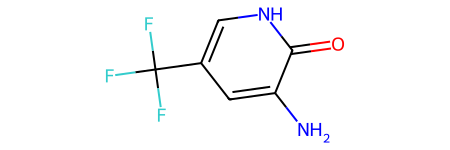

In [5]:
initial = 'Nc1cc(c[nH]c1=O)C(F)(F)F'
initial_mol = MolFromSmiles(initial)
initial_mol

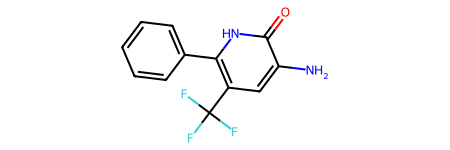

In [6]:
reinvent = 'Nc1cc(C(F)(F)F)c(-c2ccccc2)[nH]c1=O'
reinvent_mol = MolFromSmiles(reinvent)
reinvent_mol

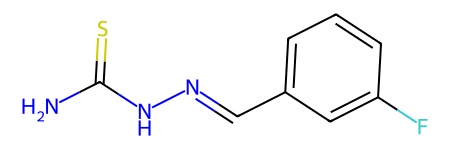

In [7]:
crem = 'NC(=S)NN=Cc1cccc(F)c1'
crem_mol = MolFromSmiles(crem)
crem_mol

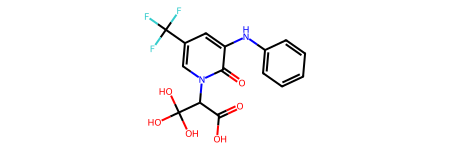

In [8]:
coati ='O=C(O)C(n1cc(C(F)(F)F)cc(Nc2ccccc2)c1=O)C(O)(O)O'
coati_mol = MolFromSmiles(coati)
coati_mol

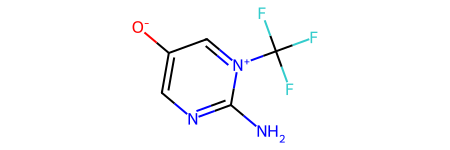

In [9]:
safe = 'Nc1ncc([O-])c[n+]1C(F)(F)F'
safe_mol = MolFromSmiles(safe)
safe_mol

,Embedding Type,KNN_Accuracy,SVM_Accuracy
0,UMAP_Embeddings,0.93,0.86
1,Molecular_Fingerprints,0.90,0.64


<Axes: xlabel='Embedding Type', ylabel='SVM_Accuracy'>

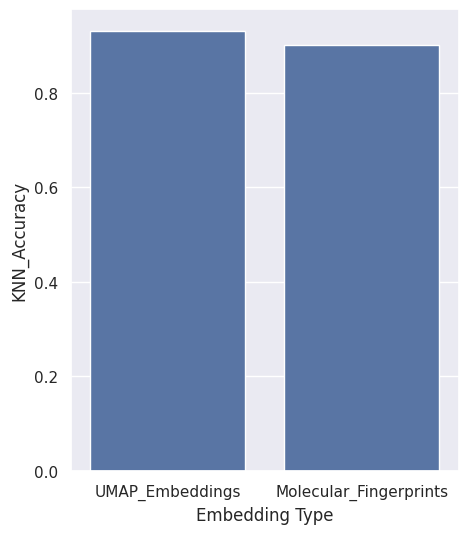

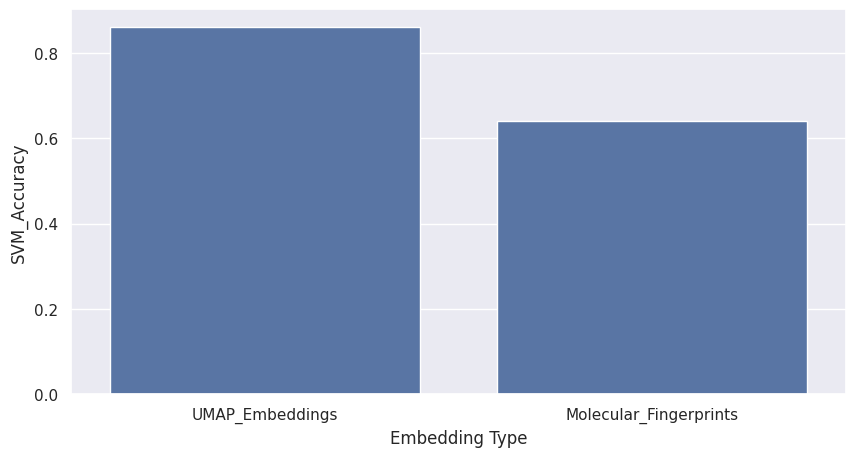

In [10]:
def tanimoto_similarity(smi_1, smi_2, use_counts=True):
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=True)
    mol_1 = Chem.MolFromSmiles(smi_1)
    mol_2 = Chem.MolFromSmiles(smi_2)
    if use_counts:
        fp_1 = rdFingerprintGenerator.GetCountFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetCountFPs([mol_2])[0]
    else:
        fp_1 = rdFingerprintGenerator.GetFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetFPs([mol_2])[0]
    return DataStructs.TanimotoSimilarity(fp_1, fp_2)

In [11]:
def remove_odd_rings(df):
    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()
    df = df.query('min_freq > 100').copy()
    return df.iloc[:, 0:3]

### Generating analogs w/ REINVENT

In [12]:
%cd ..

arg1 = f'--input_frag'
subprocess.run(['python3', 'generate_analogs.py', arg1, initial],
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay


/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [13]:
df = pd.read_csv('data/reinvent_dataframe.csv')

df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
df = df.sample(n=500)
df['Model'] = 'reinvent'

df

,SMILES,Input_SMILES,Tanimoto,Prior,Model
727,CCCNc1cc(C)[nH]c(=O)c1C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.463415,scaffold,reinvent
332,CCn1cc(C(F)(F)F)cc(N)c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.488889,mmp,reinvent
30,Nc1[nH]c(=O)c(N)cc1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.722222,high_similarity,reinvent
370,CC(C)(C)c1cc(N)c(=O)[nH]c1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.411765,mmp,reinvent
625,CCn1ccc(=O)c(N)c1F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.326531,scaffold_generic,reinvent
...,...,...,...,...,...
426,NCCCc1c[nH]c(=O)c(N)c1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.471698,mmp,reinvent
959,Nc1[nH]c(=O)ccc1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.452381,similarity,reinvent
357,Nc1cc(C(F)(F)F)cn(-c2ccncc2)c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.379310,mmp,reinvent
498,CC(C)c1cc(C(C)C)c(N)c(=O)[nH]1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.196429,scaffold_generic,reinvent


### Generating analogs w/ CReM

In [15]:
out_list = []
mutate_list = list(mutate_mol(initial_mol, db_name=crem_db, return_mol=False))

for idx, analog in enumerate(mutate_list):
    out_list.append([analog, initial])

In [16]:
temp_df = pd.DataFrame(out_list, columns=["SMILES","Input_SMILES"])

In [17]:
crem_smiles = temp_df['SMILES'].values

sim_to_initial = [tanimoto_similarity(smile, initial) for smile in crem_smiles]

In [18]:
temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'crem'

In [19]:
temp_df.head()

,SMILES,Input_SMILES,Tanimoto,Model
0,NC12CC3CC(C1)CC(F)(C3)C2,Nc1cc(c[nH]c1=O)C(F)(F)F,0.031746,crem
1,Nc1cc(-c2nn[nH]n2)ccc1F,Nc1cc(c[nH]c1=O)C(F)(F)F,0.192982,crem
2,Nc1nc2c(F)cccc2s1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.148148,crem
3,Nc1ccc(-c2ccc(F)cc2)cc1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.126984,crem
4,Nc1nc(-c2ccc(F)cc2)cs1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.133333,crem


In [20]:
df = pd.concat((df, temp_df))

In [21]:
df

,SMILES,Input_SMILES,Tanimoto,Prior,Model
727,CCCNc1cc(C)[nH]c(=O)c1C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.463415,scaffold,reinvent
332,CCn1cc(C(F)(F)F)cc(N)c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.488889,mmp,reinvent
30,Nc1[nH]c(=O)c(N)cc1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.722222,high_similarity,reinvent
370,CC(C)(C)c1cc(N)c(=O)[nH]c1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.411765,mmp,reinvent
625,CCn1ccc(=O)c(N)c1F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.326531,scaffold_generic,reinvent
...,...,...,...,...,...
480,O=c1[nH]cc(C(F)(F)F)cc1I,Nc1cc(c[nH]c1=O)C(F)(F)F,0.675676,NaN,crem
481,N#Cc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.625000,NaN,crem
482,O=c1[nH]cc(C(F)(F)F)cc1O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.675676,NaN,crem
483,O=C(O)c1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.595238,NaN,crem


### Generating analogs w/ COATI

In [22]:
encoder1, tokenizer1 = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/barlow_closed.pkl"
)

encoder2, tokenizer2 = load_coati2(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/coati2_chiral_03-08-24.pkl"
)

Loading model from s3://terray-public/models/barlow_closed.pkl
File downloaded successfully to ./models/barlow_closed.pkl
Loading tokenizer may_closedparen from s3://terray-public/models/barlow_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!
Loading model from s3://terray-public/models/coati2_chiral_03-08-24.pkl
File downloaded successfully to ./models/coati2_chiral_03-08-24.pkl
Loading tokenizer coati2_12_12 from s3://terray-public/models/coati2_chiral_03-08-24.pkl
number of parameters: 50.44M
number of parameters Total: xformer: 54.81M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
56385536 params frozen!


In [23]:
def gen_mol(smiles, coati_version=1, num_variations=100, noise_scale=0.15):

    # Embed the SMILES string
    smiles = CanonSmiles(smiles)

    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

    # Retrieve canonical SMILES of generated analogs
    unique_valid_smiles = list(set([CanonSmiles(smi) for smi in nearby_smiles if MolFromSmiles(smi)]))

    # Store true if original molecule is in the set of generated analogs
    had_orig = smiles in unique_valid_smiles

    unique_valid_smiles = list(set([smiles] + unique_valid_smiles))

    # Generate molecular fingerprints
    fp = RDKFingerprint(MolFromSmiles(smiles), minPath=1, maxPath=7, fpSize=2048)
    fps = [RDKFingerprint(MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048) for x in unique_valid_smiles]

    # Compute tanimoto similarities between distributions and store as list of strings
    sim = BulkTanimotoSimilarity(fp, fps)
    sim_str = [str(round(x, 2)) for x in sim]

    unique_valid_smiles, sim_str = zip(*sorted(zip(unique_valid_smiles, sim_str), key=lambda x:x[1], reverse=True))

    if not had_orig:
        unique_valid_smiles, sim_str = zip(*[[i, f"{j} (Added)"] if i==smiles else [i, j] for i, j in zip(unique_valid_smiles, sim_str)])

    # Output for molecule generation
    print (f"Attempted {num_variations} COATI{coati_version} generations with a noise scale of {noise_scale} and generated {len(unique_valid_smiles)} unique structures.")
    
    # Display molecules and tanimoto similarity to initial fragment
    # display(Draw.MolsToGridImage([MolFromSmiles(s) for s in unique_valid_smiles], molsPerRow=5, subImgSize=(200, 200), maxMols=100, legends=sim_str))
    
    return unique_valid_smiles

In [24]:
coati_smiles = gen_mol(initial, coati_version = 2, num_variations = 1000, noise_scale = 0.5)

Attempted 1000 COATI2 generations with a noise scale of 0.5 and generated 287 unique structures.


In [25]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = coati_smiles
temp_df['Input_SMILES'] = initial

len(temp_df)

287

In [26]:
sim_to_initial = [tanimoto_similarity(smile, initial) for smile in coati_smiles]

temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'coati'

len(temp_df)

227

In [27]:
temp_df.head()

,SMILES,Input_SMILES,Tanimoto,Model
0,Nc1cc(C(F)(F)F)c[nH]c1=O.[Na],Nc1cc(c[nH]c1=O)C(F)(F)F,0.968750,coati
1,Nc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,1.000000,coati
2,Nc1cc(C(F)(F)F)c[nH]c1=O.[H],Nc1cc(c[nH]c1=O)C(F)(F)F,0.968750,coati
3,Nc1cc(C(F)(F)F)c[nH]c1=O.[H]/[C-]=C\[O-],Nc1cc(c[nH]c1=O)C(F)(F)F,0.775000,coati
4,C=CCCN.Nc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.704545,coati


In [28]:
df = pd.concat((df, temp_df))

In [29]:
df

,SMILES,Input_SMILES,Tanimoto,Prior,Model
727,CCCNc1cc(C)[nH]c(=O)c1C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.463415,scaffold,reinvent
332,CCn1cc(C(F)(F)F)cc(N)c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.488889,mmp,reinvent
30,Nc1[nH]c(=O)c(N)cc1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.722222,high_similarity,reinvent
370,CC(C)(C)c1cc(N)c(=O)[nH]c1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.411765,mmp,reinvent
625,CCn1ccc(=O)c(N)c1F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.326531,scaffold_generic,reinvent
...,...,...,...,...,...
272,Nc1nc(=O)n(CC(F)(F)F)cc1I,Nc1cc(c[nH]c1=O)C(F)(F)F,0.288462,NaN,coati
273,Nc1cc(=O)n(CC(F)(F)F)[nH]1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.347826,NaN,coati
275,Nc1ncc([O-])c[n+]1C(F)(F)F,Nc1cc(c[nH]c1=O)C(F)(F)F,0.265306,NaN,coati
280,Nc1ncc(I)c(F)n1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.145833,NaN,coati


### Generating analogs w/ SAFE

In [30]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

In [31]:
generated_smiles = designer.super_structure(
    core=initial,
    n_samples_per_trial=200,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    attachment_point_depth=3,
)

generated_smiles

  0%|          | 0/1 [00:00<?, ?it/s]

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

['Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)n(CBr)c1=O',
 'N#[N+]c1c(C(F)(F)F)c([N+]#N)n([N+]#N)c(=O)c1N',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)F)n(CCC(F)(F)F)c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(CO)n(CC(=O)O)c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(COC(F)(F)C(F)F)n(C(F)(F)C(F)(F)F)c1=O',
 'FC(F)F.Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)n(CC(F)(F)F)c1=O',
 'Nc1c(C(=O)O)c(C(F)(F)F)c(C(=O)O)n(C(F)(F)F)c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(=O)O)n(C(F)(F)F)c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)n(CF)c1=O',
 'FC(F)F.Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)n(C(F)(F)F)c1=O',
 'Cc1c(C(F)(F)F)c(C#N)c(N)c(=O)n1C',
 'Nc1c(C(=O)O)c(C(F)(F)F)c(C(F)(F)F)n(CC(=C=O)C(=O)O)c1=O',
 'CC(F)(F)c1c(C(F)(F)F)c(C(F)(F)F)n(C(F)(F)F)c(=O)c1N',
 'Nc1c([N+](=O)[O-])c(C(F)(F)F)c([N+](=O)[O-])n([N+](=O)[O-])c1=O',
 '[N-]=[N+]=NOn1c(CCl)c(C(F)(F)F)c(C(F)(F)F)c(N)c1=O',
 'CP(=O)(O)Nc1c(C(F)(F)F)c(CN[SH](N)=O)n(C(CCl)(CCl)C(F)(F)F)c(=O)c1N',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)n(C(F)F)c1=O',
 'N#Cc1c(C(F)(F)F)c(C(F)(F)F)c(N)c(=O)n1C(

In [32]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = generated_smiles
temp_df['Input_SMILES'] = initial

In [33]:
len(temp_df)

198

In [34]:
sim_to_initial = [tanimoto_similarity(smile, initial) for smile in generated_smiles]

temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'safe'

len(temp_df)

198

In [35]:
df = pd.concat((df, temp_df))

In [36]:
df

,SMILES,Input_SMILES,Tanimoto,Prior,Model
727,CCCNc1cc(C)[nH]c(=O)c1C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.463415,scaffold,reinvent
332,CCn1cc(C(F)(F)F)cc(N)c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.488889,mmp,reinvent
30,Nc1[nH]c(=O)c(N)cc1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.722222,high_similarity,reinvent
370,CC(C)(C)c1cc(N)c(=O)[nH]c1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.411765,mmp,reinvent
625,CCn1ccc(=O)c(N)c1F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.326531,scaffold_generic,reinvent
...,...,...,...,...,...
193,FC(F)F.Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)F)n(C(F)...,Nc1cc(c[nH]c1=O)C(F)(F)F,0.187500,NaN,safe
194,[N-]=[N+]=N.[N-]=[N+]=Nc1c(C(F)(F)F)c(C(=N)NOO...,Nc1cc(c[nH]c1=O)C(F)(F)F,0.174419,NaN,safe
195,[N-]=[N+]=Nc1c(C(F)(F)F)c(N=[N+]=[N-])n(C(F)(F...,Nc1cc(c[nH]c1=O)C(F)(F)F,0.208333,NaN,safe
196,Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)n(C(Cl)(Cl...,Nc1cc(c[nH]c1=O)C(F)(F)F,0.202703,NaN,safe


## Visualizing the models in chemical space

### PCA

In [37]:
smiles = df['SMILES'].values
mols = [MolFromSmiles(smile) for smile in smiles]

In [38]:
fpgen = AllChem.GetMorganGenerator()

fingerprints = [fpgen.GetFingerprint(mol).ToList() for mol in mols]

In [39]:
df['Fingerprints'] = fingerprints

In [40]:
X = fingerprints

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [41]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X)

In [42]:
var1, var2, var3 = pca.explained_variance_ratio_

In [43]:
df['PC1'], df['PC2'], df['PC3'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2]

In [44]:
plot_df = df.sample(n=500)

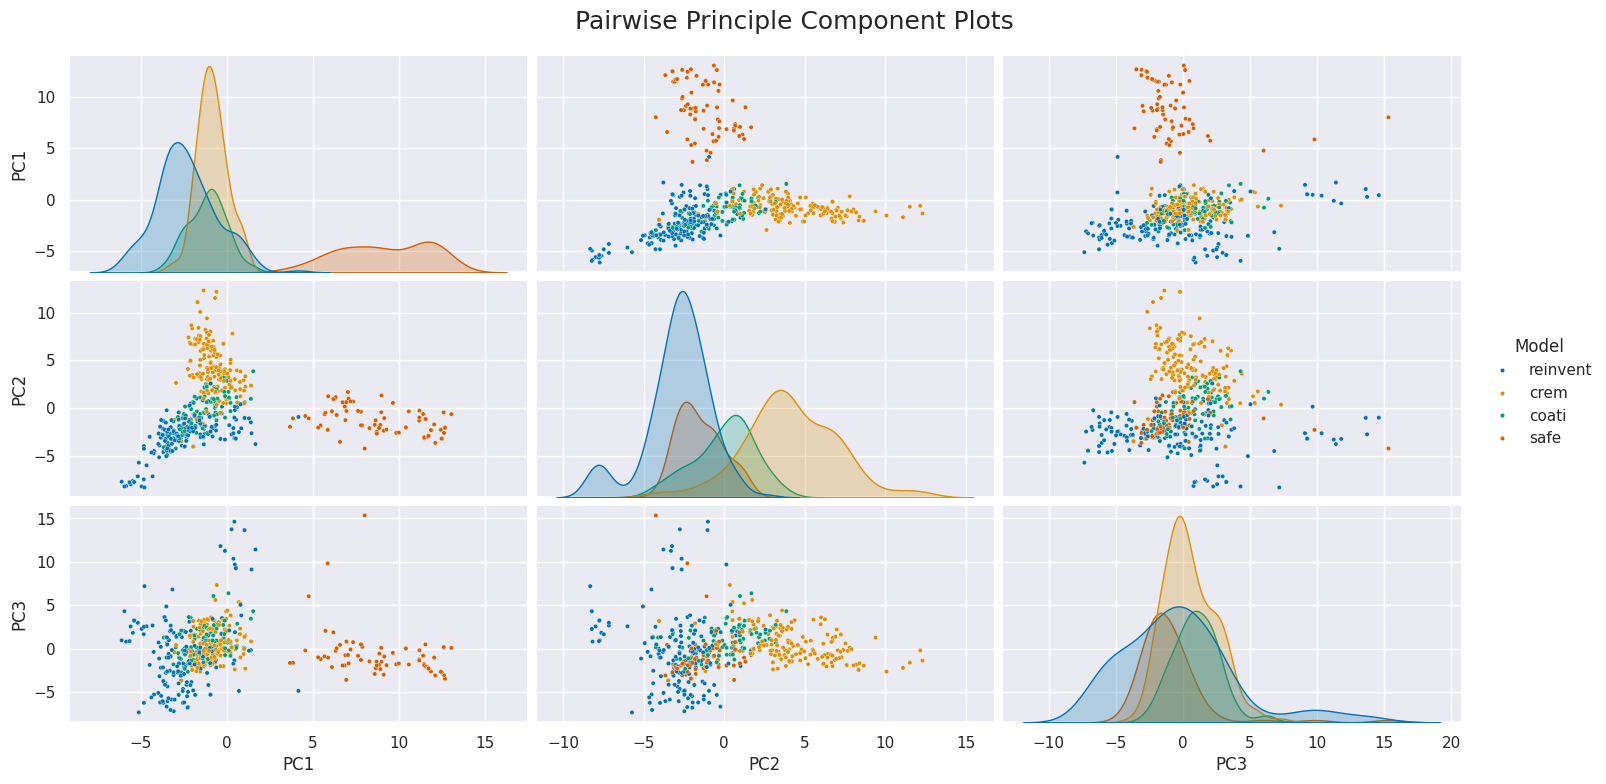

In [45]:
f = sns.pairplot(plot_df,
                 hue='Model',
                 vars=['PC1', 'PC2', 'PC3'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle('Pairwise Principle Component Plots', fontsize=18, y=1.04);

### t-SNE

In [46]:
p = 100

pca_model = PCA(n_components=5, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=5000)
tsne_fps = tsne_model.fit_transform(pca_model.fit_transform(X))

In [47]:
df['TSNE1'], df['TSNE2'] = tsne_fps.T[0], tsne_fps.T[1]

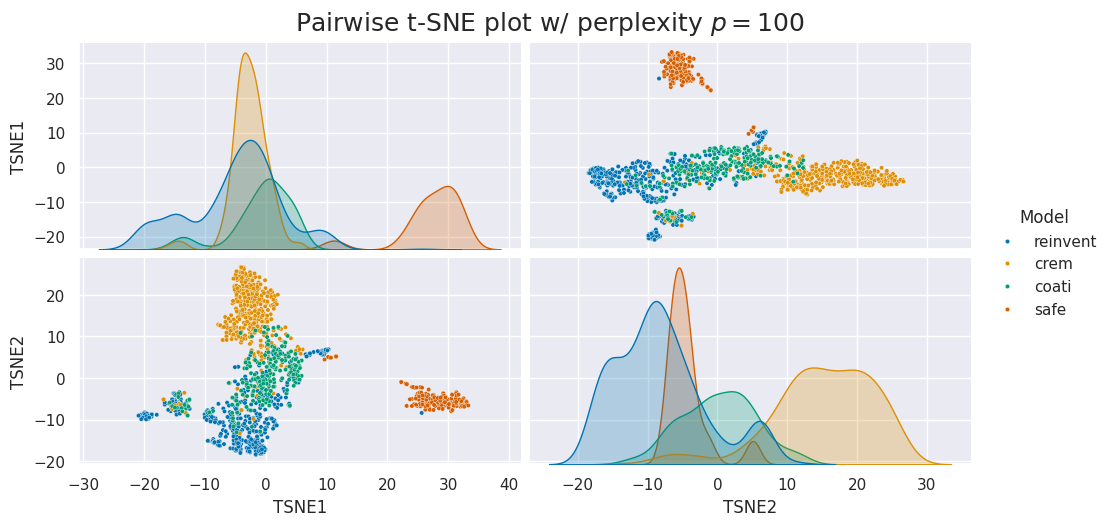

In [48]:
f = sns.pairplot(df,
                 hue='Model',
                 vars=['TSNE1', 'TSNE2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

title = f'Pairwise t-SNE plot w/ perplexity $p={p}$'

f.fig.suptitle(title, fontsize=18, y=1.04);

Define the Davies Boulin index to evaluate clustering

In [49]:
from sklearn.metrics import davies_bouldin_score

In [50]:
tsne_dvs = davies_bouldin_score(tsne_fps, df['Model'])

In [51]:
print(f'Davies-Bouldin Index for t-SNE: {tsne_dvs}')

Davies-Bouldin Index for t-SNE: 1.1146585733759826


Try UMAP

In [52]:
import umap

2024-08-09 20:05:32.577988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 20:05:32.595651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 20:05:32.600768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 20:05:32.614378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 20:05:33.658943: W tensorflow/compiler/tf2

In [53]:
# Set UMAP parameters
num_neighbors = 100 # similar to perplexity in t-SNE
reduced_dim = 2
rs = 0 # random state

# Apply UMAP
umap_model = umap.UMAP(n_components=reduced_dim, n_neighbors=num_neighbors, random_state=rs, init="pca")
umap_projection = umap_model.fit_transform(X)

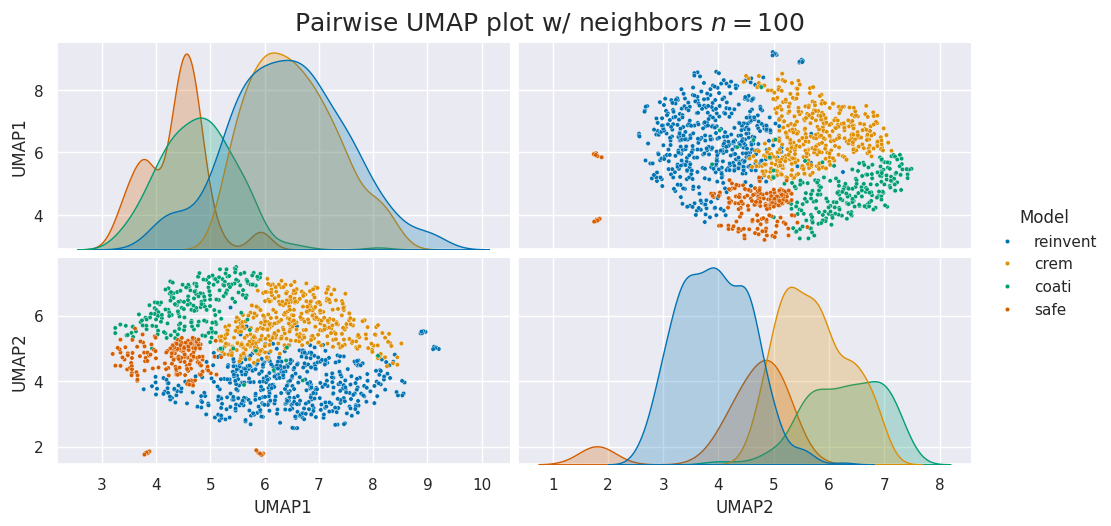

In [54]:
df['UMAP1'], df['UMAP2'] = umap_projection.T[0], umap_projection.T[1]

f = sns.pairplot(df,
                    hue='Model',
                    vars=['UMAP1', 'UMAP2'],
                    palette='colorblind',
                    aspect=2,
                    plot_kws=dict(s=10))

title = f'Pairwise UMAP plot w/ neighbors $n={num_neighbors}$'


f.fig.suptitle(title, fontsize=18, y=1.04);




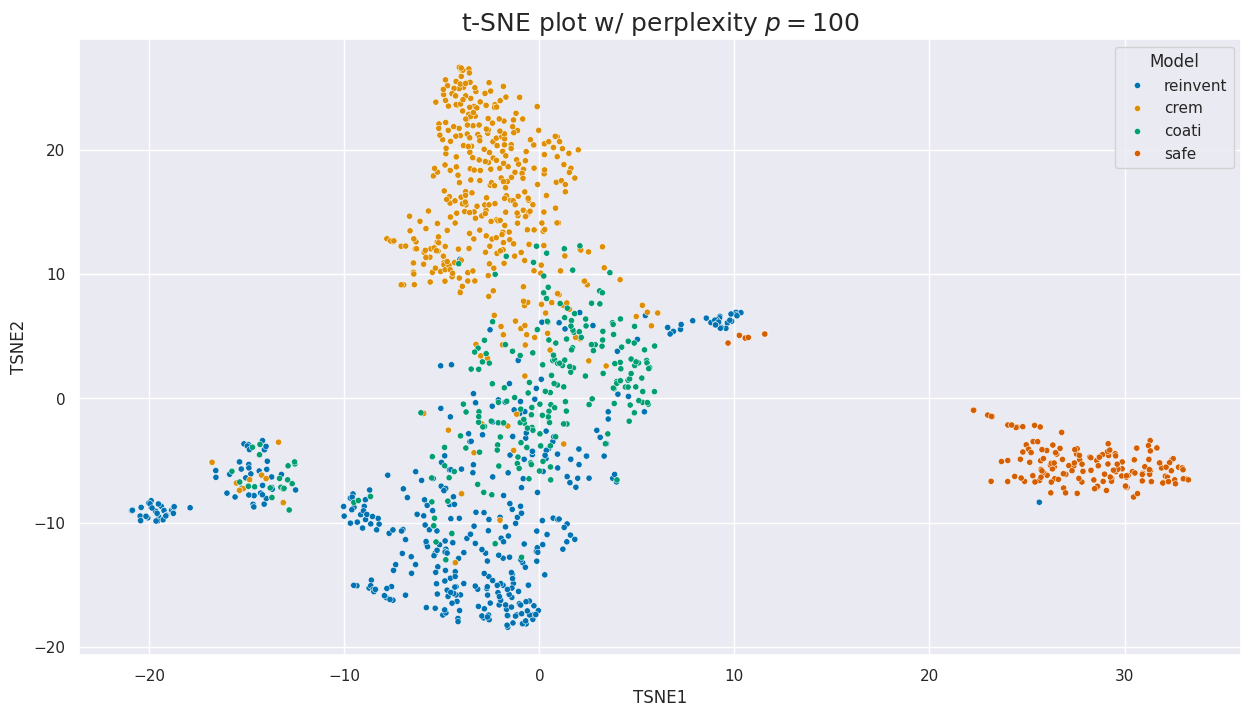

In [55]:
f = sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Model', palette='colorblind', s=20)

title = f't-SNE plot w/ perplexity $p={p}$'

plt.title(title, fontsize=18);

plt.show()

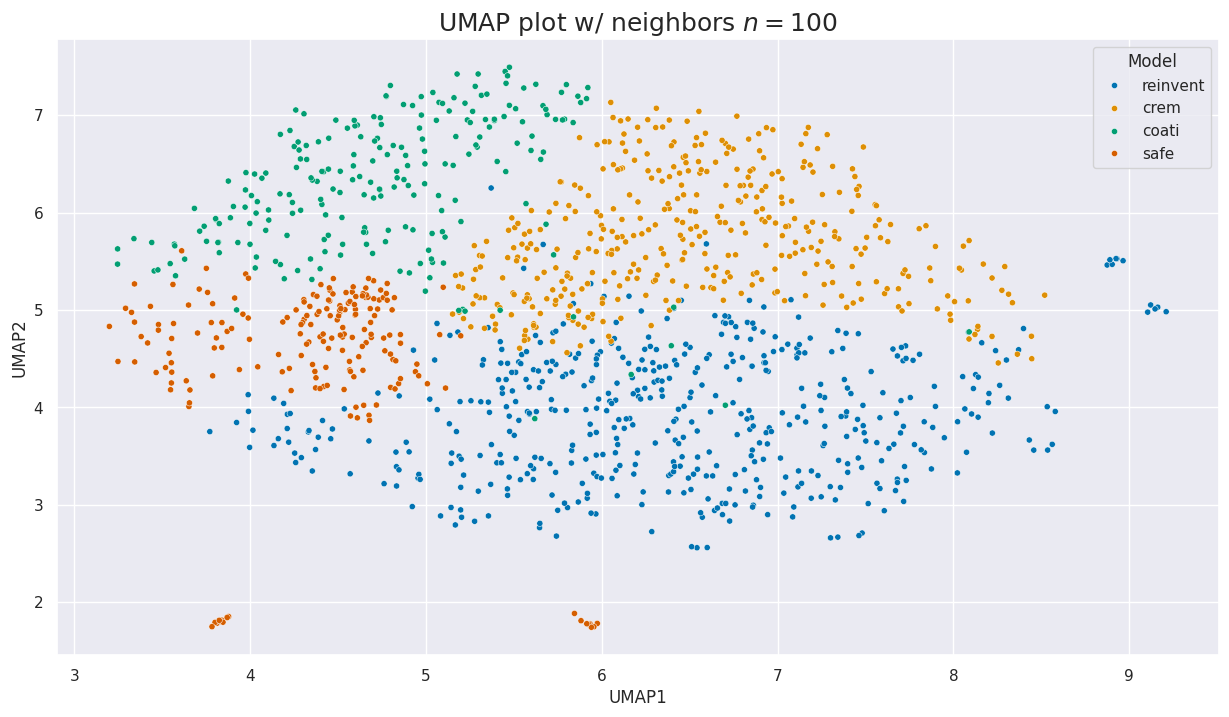

In [105]:
f = sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Model', palette='colorblind', s=20)

title = f'UMAP plot w/ neighbors $n={num_neighbors}$'

subtext = f'Random state: {rs}' 

plt.title(title, fontsize=18);

plt.show()

Calculate Davies Bouldin score for UMAP

In [106]:
umap_dvs = davies_bouldin_score(umap_projection, df['Model'])

In [107]:
print(f'Davies-Bouldin Index for UMAP: {umap_dvs}')

Davies-Bouldin Index for UMAP: 1.0292467828558731


Now we can get UMAP to learn the manifold

In [108]:
#define a train test split of the df

from sklearn.model_selection import train_test_split



In [109]:
X_train, X_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Model'], shuffle=True)

In [110]:
print(f"Train size: {len(X_train)}")

Train size: 1194


In [111]:
print(f"Test size: {len(X_test)}")

Test size: 133


In [63]:
X_train.head()

,SMILES,Input_SMILES,Tanimoto,Prior,Model,Fingerprints,PC1,PC2,PC3,TSNE1,TSNE2,UMAP1,UMAP2
889,Nc1cc(I)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.456522,similarity,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2.373609,-2.767153,-0.414953,-6.768871,-7.993798,6.869751,3.443262
187,NCCc1ccccc1S(=O)(=O)F,Nc1cc(c[nH]c1=O)C(F)(F)F,0.118644,NaN,crem,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.870116,4.667857,-1.224219,-3.546154,18.507458,6.305565,5.306606
64,NC1=NC(c2cc(F)cc(F)c2)CO1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.166667,NaN,crem,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1.769856,3.489235,1.657238,0.073055,10.093042,7.984817,4.894831
137,[11CH3]c1[nH]c(=O)c(N)nc1C(F)(F)F,Nc1cc(c[nH]c1=O)C(F)(F)F,0.361702,NaN,coati,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.524987,-1.357566,-1.880337,0.580424,-6.567024,4.418332,6.419263
32,Nc1cnc(Cl)c(C(F)(F)F)c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.347826,NaN,coati,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.655433,1.787376,1.482818,1.702726,4.083262,5.549568,6.931510


Convert each fingerprint to a numpy array

In [66]:
import numpy as np

In [67]:
X_train_fg = X_train['Fingerprints'].values

In [68]:
X_train_fg = np.array([np.array(x) for x in X_train_fg])

In [69]:
X_test_fg = X_test['Fingerprints'].values

In [70]:
X_test_fg = np.array([np.array(x) for x in X_test_fg])

In [71]:
X_test.head()

,SMILES,Input_SMILES,Tanimoto,Prior,Model,Fingerprints,PC1,PC2,PC3,TSNE1,TSNE2,UMAP1,UMAP2
406,O=c1[nH]cc(C(F)(F)F)cc1F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.339623,mmp,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2.936976,-2.681200,1.451418,-15.052752,-6.401444,7.192907,3.348574
505,CCCCc1cc(C)c(=O)[nH]c1C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.157895,scaffold_generic,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.725775,-2.560121,-8.251847,-1.621955,-18.440863,5.945618,4.680058
491,CCc1c(C)c(C)n(C)c(=O)c1N,Nc1cc(C(F)(F)F)c[nH]c1=O,0.122807,scaffold_generic,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.946718,-1.761388,-3.478822,1.591585,-11.012125,5.198504,3.180818
727,CCCNc1cc(C)[nH]c(=O)c1C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.463415,scaffold,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",-3.043204,-3.373079,-5.865326,-7.840071,-16.062750,5.851981,4.506918
303,CC(C)(C)c1c[nH]c(=O)c(N)c1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.550000,mmp,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.159308,-4.379083,-1.255445,-8.556483,-9.515437,5.569968,4.287937


In [72]:
#make dictionary of models

model_dict = {'reinvent': 0, 'crem': 1, 'coati': 2, 'safe': 3}

#now relabel the models

y_train = X_train['Model'].map(model_dict)
y_test = X_test['Model'].map(model_dict)


In [73]:
print(np.array(y_train))

[0 1 1 ... 0 3 3]


In [85]:
mapper = umap.UMAP(n_neighbors=50, random_state=0, init="pca").fit(X_train_fg, y = y_train)

In [86]:
test_embedding = mapper.transform(X_test_fg)

In [87]:
X_train['UMAP_train1'], X_train['UMAP_train2'] = mapper.embedding_[:,0], mapper.embedding_[:,1]

In [88]:
X_test['UMAP_test1'], X_test['UMAP_test2'] = test_embedding[:,0], test_embedding[:,1]

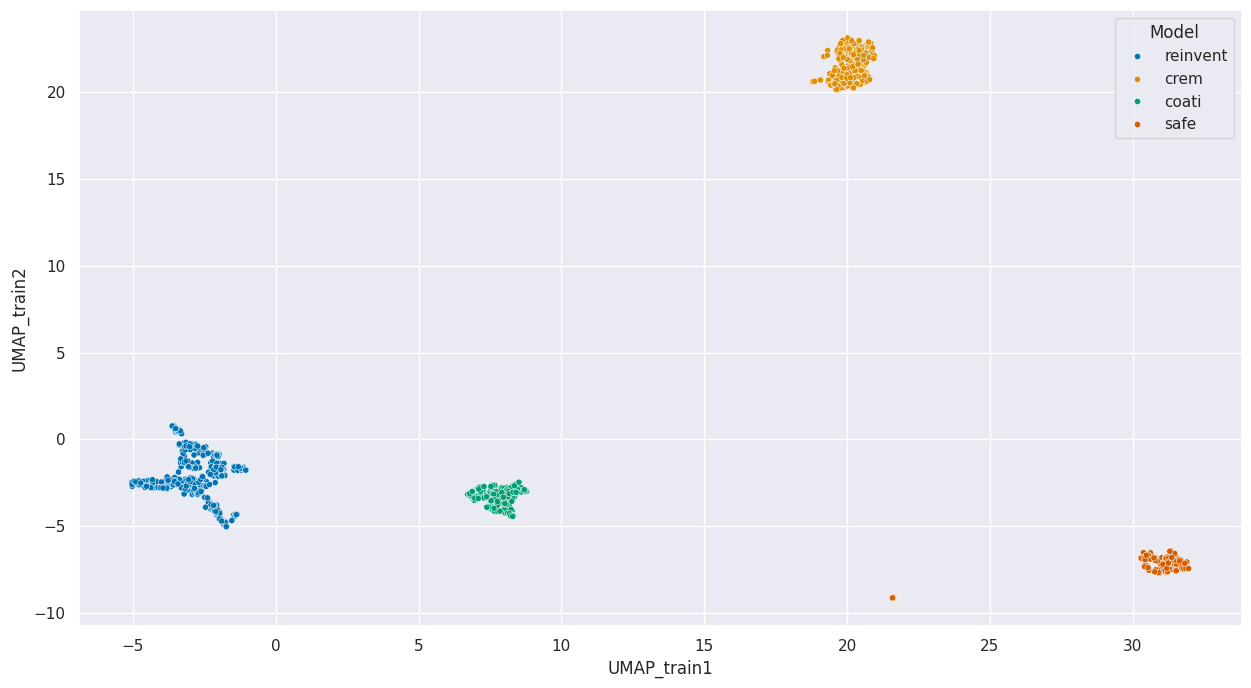

In [89]:


f = sns.scatterplot(data=X_train, x='UMAP_train1', y='UMAP_train2', hue='Model', palette='colorblind', s=20)

title = f'UMAP plot w/ neighbors $n={num_neighbors}$'


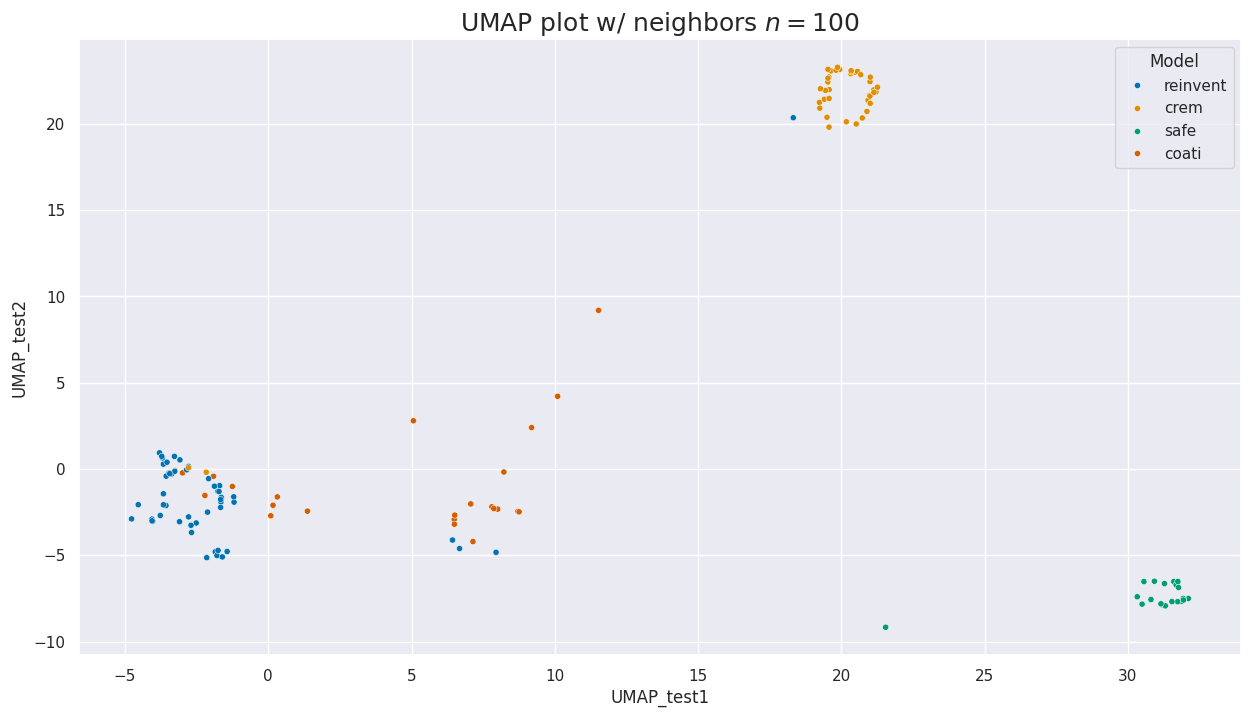

In [90]:
f = sns.scatterplot(data=X_test, x='UMAP_test1', y='UMAP_test2', hue='Model', palette='colorblind', s=20)

title = f'UMAP plot w/ neighbors $n={num_neighbors}$'

plt.title(title, fontsize=18);

plt.show()

Run KNN on the training and test dataset

In [91]:
#Run a simple classifier KNN

from sklearn.neighbors import KNeighborsClassifier


In [112]:
KNN = KNeighborsClassifier(n_neighbors=5)
UMAP_train = X_train[['UMAP1', 'UMAP2']].values
KNN.fit(UMAP_train, y_train)


KNeighborsClassifier()

In [114]:
y_pred = KNN.predict(X_test[['UMAP1', 'UMAP2']].values)

In [115]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        50
           1       0.89      1.00      0.94        40
           2       0.84      0.91      0.87        23
           3       1.00      0.75      0.86        20

    accuracy                           0.92       133
   macro avg       0.93      0.90      0.91       133
weighted avg       0.93      0.92      0.92       133



Try Linear SVM

In [119]:
from sklearn.svm import LinearSVC


In [120]:
SVC = LinearSVC()
SVC.fit(UMAP_train, y_train)

LinearSVC()

In [121]:
y_pred = SVC.predict(X_test[['UMAP1', 'UMAP2']].values)

In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        50
           1       0.84      0.93      0.88        40
           2       0.90      0.83      0.86        23
           3       0.87      0.65      0.74        20

    accuracy                           0.85       133
   macro avg       0.86      0.82      0.84       133
weighted avg       0.85      0.85      0.85       133



In [ ]:
df.head()

,SMILES,Input_SMILES,Tanimoto,Prior,Model,Fingerprints,PC1,PC2,PC3,TSNE1,TSNE2,UMAP1,UMAP2
128,Nc1cc(C(F)(F)F)cnc1O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.476190,medium_similarity,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1.976768,-0.769047,0.100576,2.288206,-3.694903,5.489590,12.124133
971,Nc1cc(CCO)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.543478,similarity,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",-3.611654,3.442364,-5.022221,-5.741641,14.365191,8.310068,8.246421
762,CC(C)(C)c1ccc(C#N)c(=O)[nH]1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.155172,scaffold,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1.088912,0.651540,-3.403554,-1.828657,8.428820,5.902914,11.750335
327,Nc1ccc[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.325000,mmp,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.027210,-0.615965,-1.453954,-2.898666,1.651431,3.200679,9.971382
480,CCCCc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.490196,mmp,reinvent,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.061492,6.360356,0.140660,-13.948709,10.186036,6.495014,9.922963


In [ ]:
sim = [tanimoto_similarity(smile, initial) for smile in df['SMILES'].values]

In [ ]:
len(sim)

1301

In [ ]:
df['Tanimoto'] = sim

<Axes: xlabel='Tanimoto', ylabel='Count'>

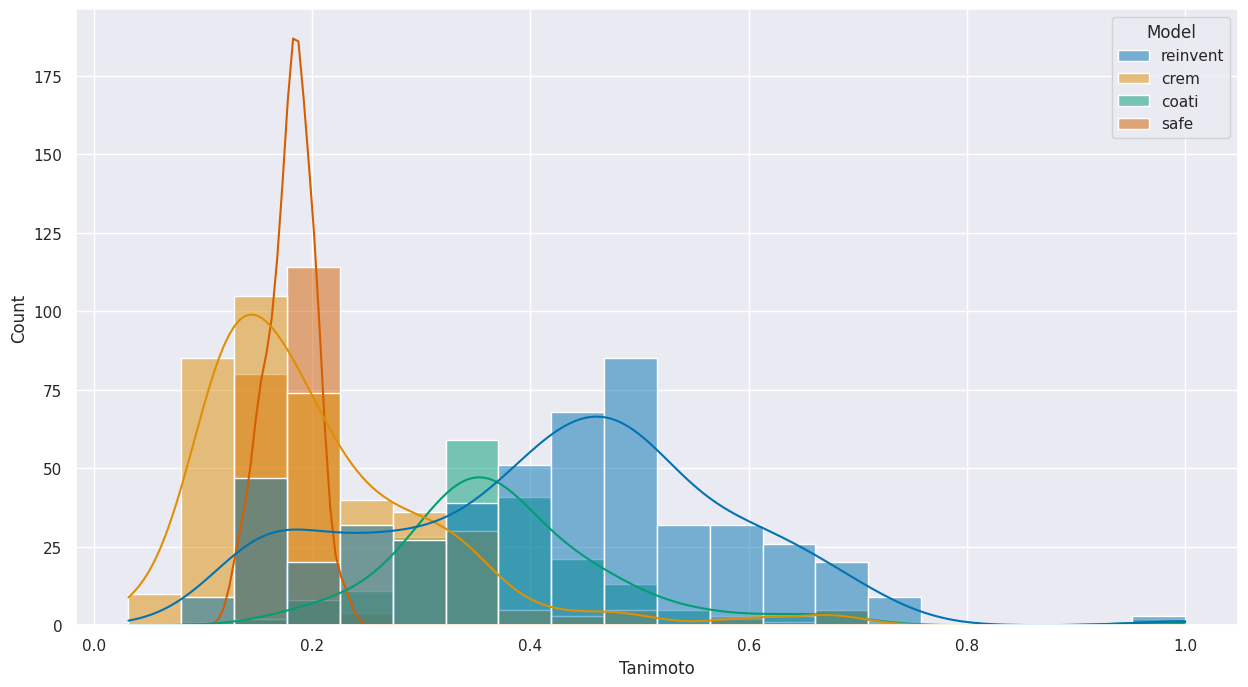

In [ ]:
sns.histplot(df, x='Tanimoto', hue='Model', bins=20, kde=True, palette='colorblind')

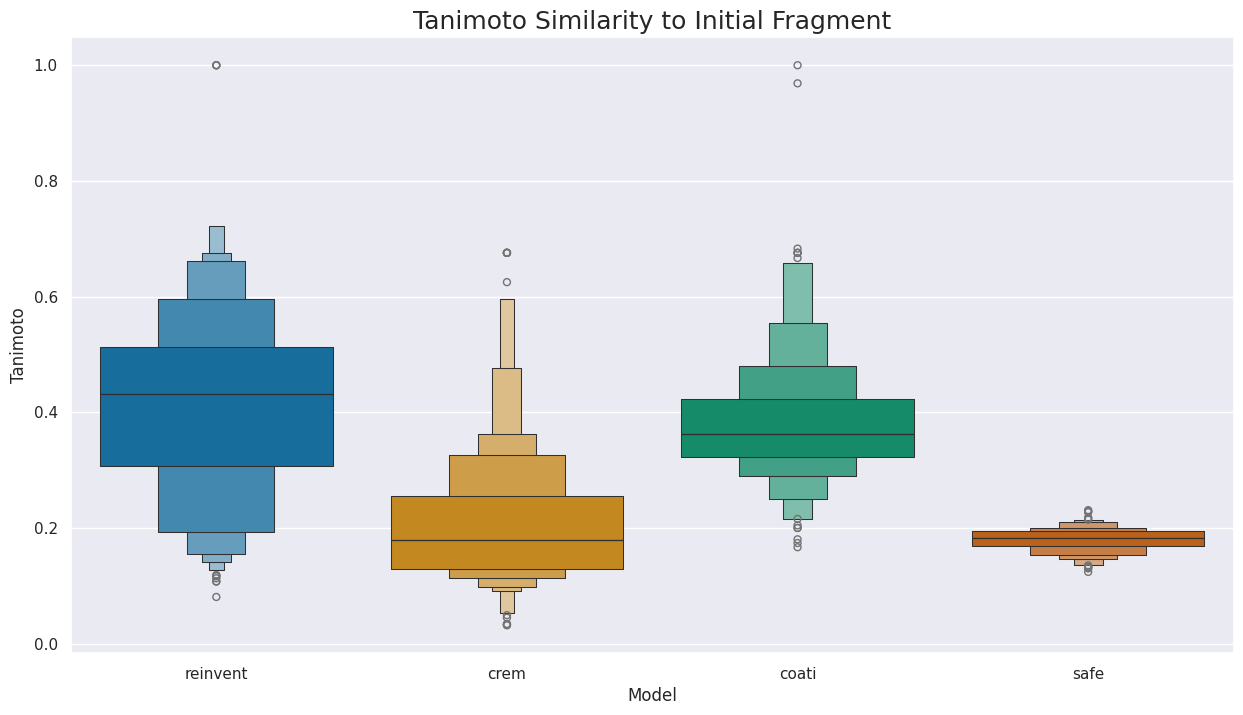

In [ ]:
sns.boxenplot(data=df, x='Model', y='Tanimoto', palette='colorblind')

plt.title('Tanimoto Similarity to Initial Fragment', fontsize=18);

plt.show()

In [ ]:
lead = 'N[C@H]1CCN(Cc2cccc(c2)c3ccc4c(=O)[nH]ccc4c3)C1'
lead_mol = MolFromSmiles(lead)

In [ ]:
lead_sim = [tanimoto_similarity(smile, lead) for smile in df['SMILES'].values]

df['Tanimoto_Lead'] = lead_sim

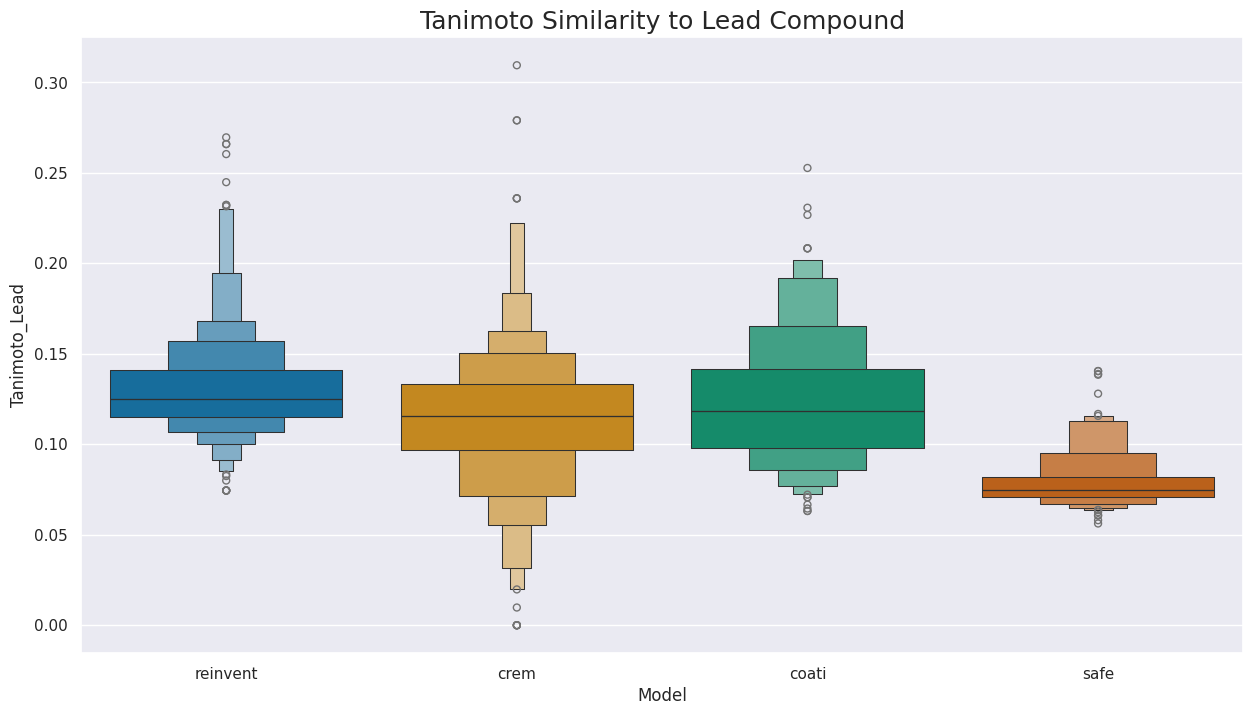

In [ ]:
sns.boxenplot(data=df, x='Model', y='Tanimoto_Lead', palette='colorblind')

plt.title('Tanimoto Similarity to Lead Compound', fontsize=18);

plt.show()

<Axes: xlabel='Tanimoto_Lead', ylabel='Count'>

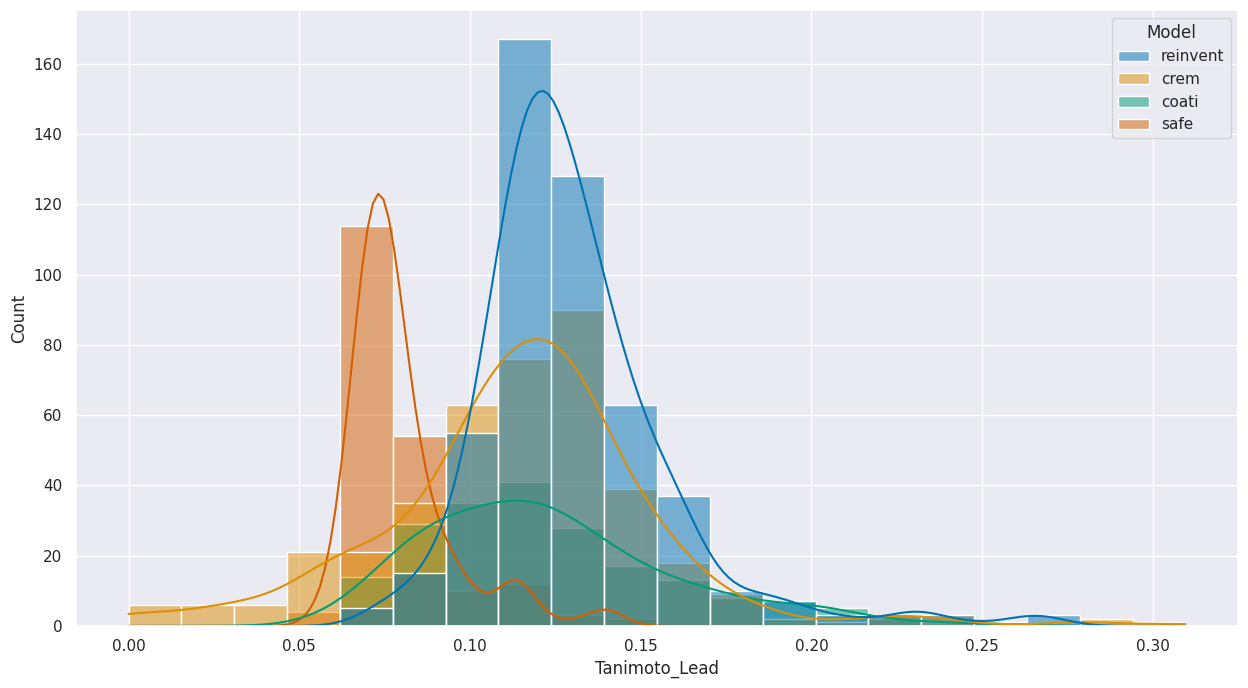

In [ ]:
sns.histplot(df, x='Tanimoto_Lead', hue='Model', bins=20, kde=True, palette='colorblind')

Get Vendi score

In [ ]:
import numpy as np

In [ ]:
def tanimoto_similarity_matrix(fps):
    sim_matrix = np.zeros((len(fps), len(fps)))
    for i in range(len(fps)):
        for j in range(len(fps)):
            sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return sim_matrix

In [ ]:
def plot_similarity_matrix(sim_matrix, title):
    plt.figure(figsize=(10, 10))
    sns.heatmap(sim_matrix, cmap='viridis')
    plt.title(title)
    plt.show()

In [ ]:
from vendi_score import vendi

In [ ]:
reinvent_fps = [fpgen.GetFingerprint(Chem.MolFromSmiles(smiles)) for smiles in df.query('Model == "reinvent"')['SMILES'].values]

In [ ]:
reinvent_sim_matrix = tanimoto_similarity_matrix(reinvent_fps)
vendi.score_K(reinvent_sim_matrix)

117.83609859254594

In [ ]:
crem_fps = [fpgen.GetFingerprint(Chem.MolFromSmiles(smiles)) for smiles in df.query('Model == "crem"')['SMILES'].values]

In [ ]:
crem_sim_matrix = tanimoto_similarity_matrix(crem_fps)
vendi.score_K(crem_sim_matrix)

210.93661459439986

In [ ]:
coati_fps = [fpgen.GetFingerprint(Chem.MolFromSmiles(smiles)) for smiles in df.query('Model == "coati"')['SMILES'].values]

In [ ]:
coati_sim_matrix = tanimoto_similarity_matrix(coati_fps)
vendi.score_K(coati_sim_matrix)

98.4742937871928

In [ ]:
safe_fps = [fpgen.GetFingerprint(Chem.MolFromSmiles(smiles)) for smiles in df.query('Model == "safe"')['SMILES'].values]


In [ ]:
safe_sim_matrix = tanimoto_similarity_matrix(safe_fps)
vendi.score_K(safe_sim_matrix)

25.426474472402116